# CV Coursework: Model 3: CNN on personal dataset

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)
- **CW Owner:** Mousuf C Zaman - Student No: 180021356

## Google Colab & Env Setup

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by: Giacomo Tarroni

!pip install facenet-pytorch

import torch
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN

%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '11 - University/Colab Notebooks/Computer Vision Lab/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

%load_ext autoreload
%autoreload 2

import sys
MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
sys.path.append(MODEL_PATH)

Classifier_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code/Classifier')
sys.path.append(Classifier_PATH)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
cuda:0
Mounted at /content/drive
['Code', 'CW_Dataset', 'Models', 'CV Report.docx', 'Other', 'Personal_Dataset', 'test_functions.ipynb', 'CV CW Progress.gdoc', 'CV Demo Script.gdoc', 'v28_CNN_test_function[Org DSet Completed].ipynb', 'v29_ownTest_CNN_test_function[COMPLETED].ipynb']


## 1: Transfer Learning

## Loading the Data

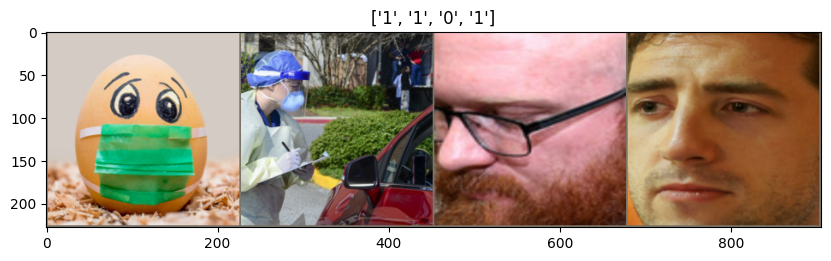

In [2]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTestCNN.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q ownTestCNN.zip

# Delete zipped version from Colab (not from Drive)
!rm ownTestCNN.zip

data_dir = 'ownTestCNN'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

mtcnn = MTCNN(keep_all=True)

def crop_face(image):
    image = np.array(image)
    faces, _ = mtcnn.detect(image, landmarks=False)
    if faces is not None:
        # crop image using the first detected face
        x1, y1, x2, y2 = faces[0].astype(int)
        cropped_image = Image.fromarray(image[y1:y2, x1:x2])
        cropped_image = cropped_image.resize((224, 224), resample=Image.BILINEAR)  # resize to 224x224
        return cropped_image
    else:
        return Image.fromarray(image)


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'ownTest': transforms.Compose([
        transforms.Lambda(crop_face), # crop image based on detected face
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'ownTest']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'ownTest']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'ownTest']}
class_names = image_datasets['train'].classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['ownTest']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=[class_names[x] for x in first_classes])
plt.show()

## Training the model

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'ownTest']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'ownTest' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['ownTest']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the CNN

In [5]:
model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Define the number of classes in your problem
num_classes = 3

from train_CNN import train_CNN
##############################################################################
# TODO: use ResNet18 as feature extractor                                    #
##############################################################################
# Modify the model to output the desired number of classes
model_ft = train_CNN(model_ft, num_classes)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 264MB/s]


## Train and evaluate

In [6]:

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------------
train loss: 0.4910 acc: 0.8325
ownTest loss: 1.1893 acc: 0.5000

Epoch 1/24
----------------
train loss: 0.4854 acc: 0.8434
ownTest loss: 1.7769 acc: 0.5000

Epoch 2/24
----------------
train loss: 0.4541 acc: 0.8521
ownTest loss: 1.6373 acc: 0.5000

Epoch 3/24
----------------
train loss: 0.3997 acc: 0.8693
ownTest loss: 1.4012 acc: 0.4583

Epoch 4/24
----------------
train loss: 0.4204 acc: 0.8642
ownTest loss: 1.9973 acc: 0.3750

Epoch 5/24
----------------
train loss: 0.4453 acc: 0.8555
ownTest loss: 1.4315 acc: 0.5000

Epoch 6/24
----------------
train loss: 0.4014 acc: 0.8663
ownTest loss: 1.4543 acc: 0.5417

Epoch 7/24
----------------
train loss: 0.3772 acc: 0.8680
ownTest loss: 1.4240 acc: 0.4583

Epoch 8/24
----------------
train loss: 0.3551 acc: 0.8755
ownTest loss: 1.5465 acc: 0.5417

Epoch 9/24
----------------
train loss: 0.3654 acc: 0.8780
ownTest loss: 1.2154 acc: 0.5000

Epoch 10/24
----------------
train loss: 0.3322 acc: 0.8881
ownTest lo

In [ ]:
torch.save(model_ft.state_dict(), 'CNN_personal_Datset.pth')
model_ft.load_state_dict(torch.load('CNN_personal_Datset.pth'))

## Result

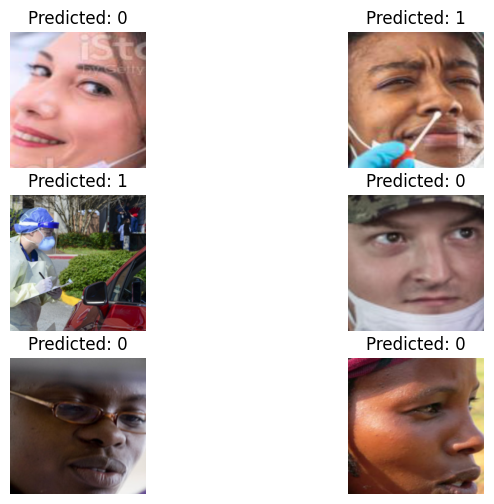

              precision    recall  f1-score   support

           0       0.46      0.75      0.57         8
           1       0.73      0.89      0.80         9
           2       0.00      0.00      0.00         7

    accuracy                           0.58        24
   macro avg       0.40      0.55      0.46        24
weighted avg       0.43      0.58      0.49        24



In [7]:
plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

from sklearn.metrics import classification_report

# Set model to evaluate mode
model_ft.eval()

# Get predictions on test data
y_preds = []
y_true = []
for inputs, labels in dataloaders['ownTest']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.tolist())
        y_true.extend(labels.tolist())

# Compute classification report
print(classification_report(y_true, y_preds, zero_division=0))